In [1]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch

## Data Loading

In [3]:
df = pd.read_csv(os.path.abspath("/home/sneha/e5lungairwaysvida_20140211.csv"))

/tmp/ipykernel_13129/2712292443.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.abspath("/home/sneha/e5lungairwaysvida_20140211.csv"))


In [4]:
df.drop(columns = ["manufacturer", "model"], inplace=True)

In [77]:
print(len(df))
df.dropna(subset=['startbpid', 'endbpid', 'idno', 'dircosx', 'dircosy', 'dircosz', 'centerlinelength', 'segmentalgeneration' ], inplace=True)
print(len(df))

992300
992104


## Data Exploration 

### Segment Analysis

In [78]:


summary = df.groupby("idno").agg(
    {
        "anatomicalname":"count"
    }
).rename(
    columns = {
        "anatomicalname":"num_branch_segments"
    }
).sort_values(
    by="num_branch_segments",
    ascending=False
).describe().round(0).astype(int)
display(summary)
print(f"There are {summary.loc[summary.index=='count']['num_branch_segments'].item()} participants, each participant has on average {summary.loc[summary.index=='mean']['num_branch_segments'].item()} \pm {summary.loc[summary.index=='std']['num_branch_segments'].item()} branch segments")

,num_branch_segments
count,2998
mean,331
std,130
min,37
25%,240
50%,321
75%,407
max,1015


There are 2998 participants, each participant has on average 331 \pm 130 branch segments


In [8]:
# Looking for orphan branches (check every branch has a parent)
# check if every startbpid (parent) is in the list of endbpids for that idno --> ie. the parent of the branch is in the tree. 
#If the parent is not in the list of segments (endbpid) then the branch is an orphan.
orphan_check = pd.concat([df[["idno"]].copy(), df.apply(
    lambda x: x.startbpid in df[df.idno == x.idno]['endbpid'].values,
axis=1)], axis=1)

# concatenate
orphan_check.rename({0:"has_parent"}, axis=1, inplace=True)


In [16]:
df.loc[df.startbpid == -1]

,idno,subject_name,subject_id,session_id,study_date,study_time,series_id,series_name,series_uid,series_date,...,minorouterdiam_70,majorouterdiam_70,outercrosssecarea_70,avgwallthickness_70,minwallthickness_70,maxwallthickness_70,innerperimeter_70,outerperimeter_70,innerequivalentcirclediameter_7,scan_problem
0,3010007,MESA^JACKPE^M,H-4824,MESA-3010007-E5,30NOV2010:00:00:00.000,30DEC1899:08:44:28.000,12592708.0,LUNG INSPIRATION,NaN,30NOV2010:00:00:00.000,...,23.9746,26.2265,495.087,2.27876,2.10939,3.07135,63.9036,79.9426,20.3412,0
381,3010058,MESA^KELSER^F,H-9037,MESA-3010058-E5,23NOV2011:00:00:00.000,30DEC1899:11:21:32.000,22428304.0,LUNG INSPIRATION,NaN,23NOV2011:00:00:00.000,...,19.1830,24.3801,360.077,2.28717,2.00658,2.67257,53.6754,68.6768,17.0854,0
844,3010082,MESA^REIDCO^F,H-5775,MESA-3010082-E5,10AUG2011:00:00:00.000,30DEC1899:08:11:41.000,21198532.0,LUNG INSPIRATION,NaN,10AUG2011:00:00:00.000,...,19.1360,20.9622,309.097,2.06114,1.69969,2.62882,49.3382,63.7620,15.7048,0
1315,3010090,MESA^CLARVE^F,H-1623,MESA-3010090-E5,08JUN2011:00:00:00.000,30DEC1899:08:20:53.000,18617670.0,LUNG INSPIRATION,1.2.840.113619.2.55.3.194535200.632.1307532655...,08JUN2011:00:00:00.000,...,18.4607,23.3890,336.483,2.31134,1.84831,2.85747,50.4810,66.8659,16.0686,0
1496,3010112,MESA^ROSEPE^F,H-950,MESA-3010112-E5,11MAR2011:00:00:00.000,30DEC1899:08:12:52.000,13661334.0,LUNG INSPIRATION,1.2.840.113619.2.55.3.194535200.772.1299847503...,11MAR2011:00:00:00.000,...,20.9463,25.3523,405.066,2.26703,2.04416,2.66069,57.5486,72.5512,18.3183,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990931,8024863,MESA^DURAMA^F,H-3471,MESA-8024863-E5,11JUN2011:00:00:00.000,30DEC1899:09:19:39.000,19419094.0,Chest TLC (Inspiration),1/3/2012,11JUN2011:00:00:00.000,...,20.9157,23.2429,369.442,2.70582,2.11495,3.09634,51.7417,69.3480,16.4699,0
991141,8024880,MESA^REYEVI^F,H-1534,MESA-8024880-E5,28JUL2011:00:00:00.000,30DEC1899:10:43:57.000,21059529.0,Chest TLC (Inspiration),1/3/2012,28JUL2011:00:00:00.000,...,18.5392,20.5240,296.222,2.36229,1.95508,2.74749,46.2331,62.1233,14.7164,0
991300,8024952,MESA^VALIEN^F,H-5941,MESA-8024952-E5,18AUG2011:00:00:00.000,30DEC1899:10:42:52.000,21463453.0,Chest TLC (Inspiration),1/3/2012,18AUG2011:00:00:00.000,...,18.5422,20.7253,301.858,2.21928,1.96298,2.51300,47.8038,62.5458,15.2164,0
991706,8024979,MESA^DELGLE^F,H-1689,MESA-8024979-E5,07JUN2011:00:00:00.000,30DEC1899:11:52:29.000,19388218.0,Chest TLC (Inspiration),1/3/2012,07JUN2011:00:00:00.000,...,20.7067,23.0680,368.725,2.53572,2.01182,3.05086,51.9824,69.5689,16.5465,0


In [67]:
# drop trachea which never has a parent
# groupby id number and check how branches have parents vs number of branches per idno
print(len(df))
without_trachea = orphan_check.loc[df.startbpid != -1]
print("removing trachea", len(without_trachea))
per_id = without_trachea.groupby("idno").agg({"has_parent":lambda x:sum(x), "idno":"count"}) 
# display(per_id)
check = (per_id.has_parent == per_id.idno) # match count of segments per person vs count of segments with parents
# display(check)
print(f'There are {(per_id.idno-per_id.has_parent).sum()} orphan segments (excluding trachea) ({100*(~without_trachea.has_parent).sum()/len(orphan_check):.2f}% of all segments)')
print(f"Orphan segments are present in {100*check.sum()/len(check)}% of participants data")


992300
removing trachea 989288
There are 280 orphan segments (excluding trachea) (0.03% of all segments)
Orphan segments are present in 92.70507201001878% of participants data


In [68]:
# illustrative example orphan
df.loc[(df.idno==4021010) & ((df.startbpid == 593) | (df.endbpid == 593))][['idno', 'startbpid', 'endbpid', 'dircosx', 'centerlinelength']]

,idno,startbpid,endbpid,dircosx,centerlinelength
364138,4021010,593.0,631.0,0.000000,1.610380
364139,4021010,593.0,618.0,0.707107,0.828641
364140,4021010,593.0,619.0,-0.894427,1.310200
364141,4021010,593.0,620.0,0.577350,0.967805


### Generation Analysis

In [69]:
df.columns.to_list()

['idno',
 'subject_name',
 'subject_id',
 'session_id',
 'study_date',
 'study_time',
 'series_id',
 'series_name',
 'series_uid',
 'series_date',
 'series_time',
 'kernel',
 'case_id',
 'case_name',
 'analyst',
 'peer_reviewer',
 'set_id',
 'set_vgroup',
 'cuser',
 'other_ids',
 'airway_id',
 'anatomicalname',
 'centerlinelength',
 'generation',
 'segmentalgeneration',
 'lobe',
 'sublobe',
 'endbpid',
 'startbpid',
 'angle',
 'dircosx',
 'dircosy',
 'dircosz',
 'numberofavgpoints',
 'avgminorinnerdiam',
 'stddevminorinnerdiam',
 'avgmajorinnerdiam',
 'stddevmajorinnerdiam',
 'avginnerarea',
 'stddevinnerarea',
 'avgavgwallthickness',
 'stddevavgwallthickness',
 'avgminwallthickness',
 'stddevminwallthickness',
 'avgmaxwallthickness',
 'stddevmaxwallthickness',
 'minminorinnerdiam',
 'maxminorinnerdiam',
 'minmajorinnerdiam',
 'maxmajorinnerdiam',
 'mininnerarea',
 'maxavginnerarea',
 'minavgwallthickness',
 'maxavgwallthickness',
 'minminwallthickness',
 'maxminwallthickness',
 'minma

In [79]:
print("Number of weibel generations per participant")

weibel = df.groupby("idno").agg(
    {
        "segmentalgeneration":["max", "mean"]
    }
)






new_cols = [first+"_"+second for (first, second) in weibel.columns]
weibel.columns = new_cols
weibel.describe().round().astype(int)

Number of weibel generations per participant


,segmentalgeneration_max,segmentalgeneration_mean
count,2998,2998
mean,10,5
std,1,1
min,-1,-1
25%,9,5
50%,10,5
75%,11,6
max,15,7


Discrepancy between the vida labelled generation vs the weibel_generation given in the df.
VIDA: 6.52 \pm 1.94
WEIBEL:5.37 \pm 2.52  


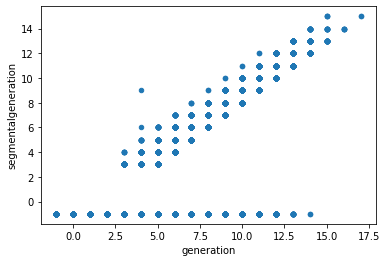

In [100]:
# weibel gen vs gen labelled by vida --> from data dictionary Generation: This is not a useful variable, but is output by VIDA. It is a rough count of airway generation (trachea = 0), but it forces some anatomic airways to have specific values.

print(f"Discrepancy between the vida labelled generation vs the weibel_generation given in the df.\nVIDA: {df.generation.mean():.2f} \pm {df.generation.std():.2f}\nWEIBEL:{df.segmentalgeneration.mean():.2f} \pm {df.segmentalgeneration.std():.2f}  ")
df.plot.scatter(x="generation", y="segmentalgeneration")
plt.show()

In [111]:
df.loc[df.segmentalgeneration == -1][['segmentalgeneration', 'generation']]

,segmentalgeneration,generation
0,-1.0,0.0
1,-1.0,1.0
2,-1.0,1.0
3,-1.0,2.0
4,-1.0,2.0
...,...,...
992148,-1.0,7.0
992210,-1.0,8.0
992211,-1.0,8.0
992212,-1.0,8.0


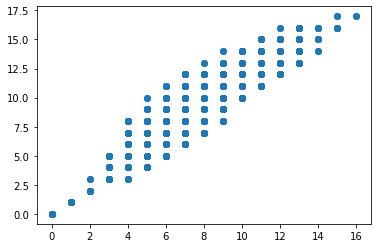

In [99]:
# test for segmental generation vs weibel (load pilot data)
pilot = pd.read_csv('../airway_tree_pilot_clean.csv')
plt.scatter(pilot.generation, pilot.weibel_generation)

In [96]:
pilot_ids = pilot.idno.unique()

filtered_df[['startbpid', 'endbpid', 'idno', 'dircosx', 'dircosy', 'dircosz', 'centerlinelength','segmentalgeneration']].head(), pilot.head()

ValueError: Can only compare identically-labeled Series objects

### Label Analysis

In [ ]:
# what is unnamed vs just empty entry in the csv? is it checked vs unchecked?
print(f"{(df['anatomicalname']=='-').sum()} branch segments have empty entries in anatomicalname")
values, counts = np.unique(df.anatomicalname.dropna().astype(str), return_counts=True)
frequ_dict = dict(zip(values, counts))
unnamed = [v for k, v in frequ_dict.items() if 'unnamed' in k.lower()]
not_unnamed = [k for k in frequ_dict.keys() if (not 'unnamed' in k.lower()) and (k != '-')]
print(f"{sum(unnamed)} branch segments have the word 'unnamed' in their anatomicalname entry")
print(f"There are {len(not_unnamed)} unique, valid anatomical names: {not_unnamed}")
# ({df[~df['anatomicalname'].str.contains('unnamed')].anatomicalname.nunique()} unique types of valid label)") 
label_freq = df.groupby('anatomicalname').agg({'idno':'nunique'}).sort_values(by='idno', ascending=False).rename({"idno":"# segments"}, axis=1).reset_index()
label_freq["grouped_anatomicalname"] = label_freq.anatomicalname.apply(lambda x: x if 'unnamed' not in x else 'unnamed-X')
f, ax = plt.subplots()
label_freq[["grouped_anatomicalname","# segments"]].groupby("grouped_anatomicalname").agg("sum").reset_index().sort_values(by="# segments", ascending=False).plot.bar(x="grouped_anatomicalname", y="# segments", ax=ax)
plt.title("Plot of branch segment frequency in dataset per anatomical name")
plt.ylabel("# segments")


In [ ]:
# for each named branch what % of patients have that branch
((df[
    ~(
        (df["anatomicalname"].str.lower().str.contains("unnamed"))| # filter dataframe to only look at normal labels
        (df["anatomicalname"]=="-")
    )
].groupby("anatomicalname").agg(
    {"idno":"count"} # check number of ids per name
)/df.idno.nunique())*100
).sort_values(
    by="idno",
    ascending=True
).reset_index().rename(
    {"idno":"% of patients that have this branch label"}, 
    axis=1
).round(2)

In [ ]:
print("All branches start at trachea and end on segment number 340\pm 132")
df.groupby("idno").agg({"startbpid":"min", "endbpid":max}).describe().round()

### Lobe Analysis

In [ ]:
df.columns.to_list()

In [ ]:
# branches per lobe, are there more labelled branches for some lobes?
def real_name(x):
    if x == "-":
        return "none"
    elif "unnamed-" in x:
        return "unnamed-X"
    else: 
        return "anatomical_label"

branches_per_lobe_df = df.copy().dropna()
branches_per_lobe_df["check_anatomicalname"] = branches_per_lobe_df["anatomicalname"].apply(lambda x: real_name(x))

# branches_per_lobe_df["realanatomicalname"] =0
# branches_per_lobe_df[ ~(
#         (branches_per_lobe_df["anatomicalname"].str.lower().str.contains("unnamed"))| # filter dataframe to only look at normal labels
#         (branches_per_lobe_df["anatomicalname"]=="-")
#     )]["realanatomicalname"] = 1
# branches_per_lobe_df.sort_values(by="realanatomicalname")
per_lobe_analysis = branches_per_lobe_df.groupby(
    [
        pd.Grouper("lobe"),
        pd.Grouper("check_anatomicalname")
    ]
).agg(
    {
        "idno":"count", 
        "angle": "mean",
        "centerlinelength":"mean",
        "segmentalgeneration":"max"
    })
per_lobe_analysis.rename(
    {
        "idno":"num_segments",
        "angle":"mean_branch_angle",
        "centerlinelength":"mean_branch_length",
        "segmentalgeneration":"max_weibel_generation"
    }, axis=1, inplace=True)
print("Looking at each lobe and splitting out whether the branch is labelled, has no label or is labeled unnamed-X")
display(per_lobe_analysis)
print("Aggregating at lobel level")
display(per_lobe_analysis.reset_index().groupby("lobe").agg({
    "num_segments":"sum", 
    "max_weibel_generation":"max",
"mean_branch_angle": ["mean", "std"],
"mean_branch_length":  ["mean", "std"]}).reset_index().sort_values(by=("num_segments", "sum"), ascending=True)
       )

### Branch Length Analysis

In [ ]:
branch_length_df = df[["idno", "segmentalgeneration", "centerlinelength"]].copy().groupby("segmentalgeneration").agg({"centerlinelength":"mean",
                                                                                       "idno":"nunique"}).rename({"idno":"num_patients", "centerlinelength":"mean_branch_length"}, axis=1)
f, ax= plt.subplots()
branch_length_df.reset_index().plot(x="segmentalgeneration", y="mean_branch_length", ax=ax)
plt.title("Variation in mean branch length with weibel generation") # NOTE NOT SURE ON UNITS

In [ ]:
# does this change lobe by lobe?

branch_length_per_lobe = df[["idno", "segmentalgeneration", "centerlinelength", "lobe"]].copy().groupby(
[
    pd.Grouper("lobe"),
    pd.Grouper("segmentalgeneration")
]).agg({"centerlinelength":["mean", "std"]}).reset_index()

display(branch_length_per_lobe)
colours = {"0":"blue",
          "1":"red",
          "2": "green",
          "3":"orange",
          "4": "purple",
          "5":"brown"}

fig,ax = plt.subplots()

for name in branch_length_per_lobe.lobe.unique():
    ax.errorbar(branch_length_per_lobe[branch_length_per_lobe.lobe==name]["segmentalgeneration"],
            branch_length_per_lobe[branch_length_per_lobe.lobe==name][("centerlinelength","mean")],
            label=name, 
            yerr=branch_length_per_lobe[branch_length_per_lobe.lobe==name][("centerlinelength","std")],
            capsize=3,
               elinewidth=1,
               color=colours[str(int(name))])

ax.set_xlabel("segmentalgeneration")
ax.set_ylabel("mean_centerlinelength")
ax.legend(loc='best')


fig,ax = plt.subplots()

for name in [x for x in branch_length_per_lobe.lobe.unique() if x != 0]:
    ax.errorbar(branch_length_per_lobe[branch_length_per_lobe.lobe==name]["segmentalgeneration"],
            branch_length_per_lobe[branch_length_per_lobe.lobe==name][("centerlinelength","mean")],
            label=name, 
            yerr=branch_length_per_lobe[branch_length_per_lobe.lobe==name][("centerlinelength","std")],
            capsize=3,
            elinewidth=1,
            color=colours[str(int(name))]
            )

ax.set_xlabel("weibel_generation")
ax.set_ylabel("mean_centerlinelength")
ax.legend(loc='best')
ax.set_title("Removing the CEN 'lobe'")

### Angle Analysis

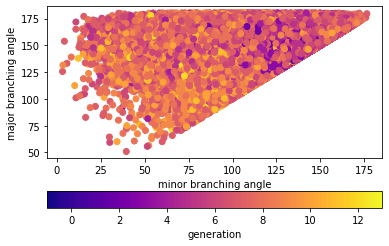

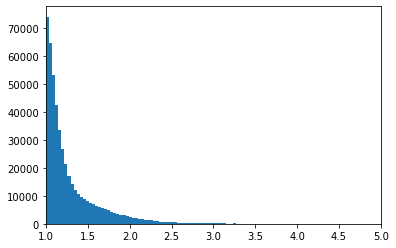

In [149]:
# plot major vs minor branching angle, coloured by generation

per_bp = df.groupby([pd.Grouper('idno'),pd.Grouper('startbpid')]).agg({
    "angle":[min, max],
    "generation": min
}).reset_index().dropna()

per_bp.columns = ['idno', 'startbpid', 'min_angle', 'max_angle', 'generation']
per_bp = per_bp[per_bp.generation <= 13]

plt.figure()
plt.scatter(per_bp.min_angle, per_bp.max_angle, c=per_bp.generation,cmap='plasma', alpha=1)
plt.colorbar(label="generation", orientation="horizontal")
plt.xlabel("minor branching angle")
plt.ylabel("major branching angle")

plt.show()

# major-minor angle ratio
ratio = per_bp.max_angle / per_bp.min_angle
plt.figure()
plt.hist(ratio, bins=1000) # removing an outlier w ratio 35
plt.xlim(1,5)
plt.show()

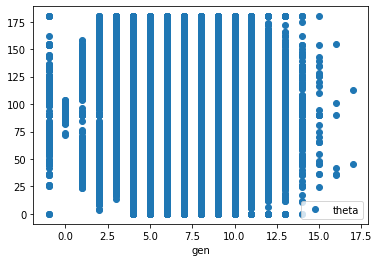

In [120]:
theta_ = np.arccos(df.dircosx.values)*180/np.pi
phi_ = np.arccos(df.dircosz.values)*180/np.pi

gen = df.generation.values
angle_df = pd.DataFrame({"gen":gen,"theta":theta_, "phi":phi_})
# angle_df.plot(x='gen', y='theta',linestyle='None', marker='o')
# plt.show()

In [157]:
max_theta = np.max(theta_)
min_theta = np.min(theta_)
nbins = 20
bins = list(range(int(min_theta), int(max_theta)+1, nbins))
bins

[0, 20, 40, 60, 80, 100, 120, 140, 160, 180]

Num segments in generation 0: 2996
Num segments in generation 1: 6027
Num segments in generation 2: 12048
Num segments in generation 3: 41028
Num segments in generation 4: 75289
Num segments in generation 5: 140150
Num segments in generation 6: 204349
Num segments in generation 7: 212520
Num segments in generation 8: 156467
Num segments in generation 9: 86161
Num segments in generation 10: 37401
Num segments in generation 11: 12835
Num segments in generation 12: 3511
Num segments in generation 13: 769
Num segments in generation 14: 168
Num segments in generation 15: 33
Num segments in generation 16: 6


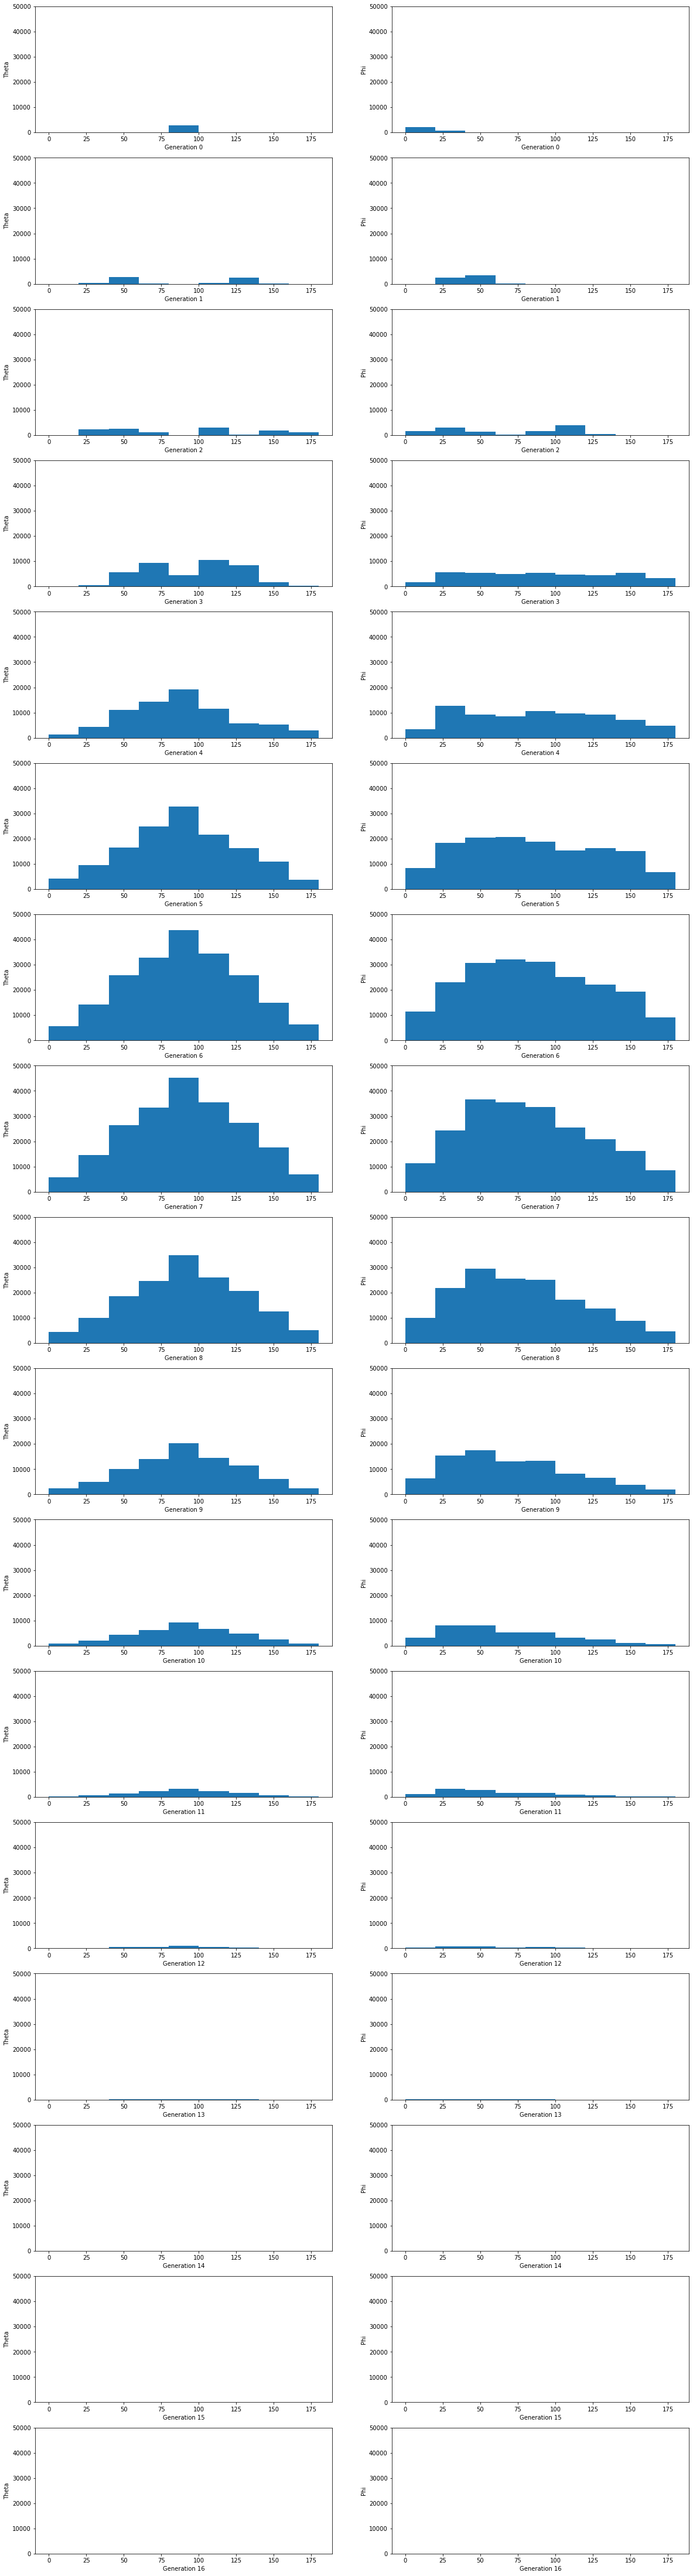

In [158]:
num_subplots = int(angle_df.gen.max())
f, axs = plt.subplots(int(num_subplots),2, figsize=(20,80))
for i in range(num_subplots):
    gen = i
    print(f"Num segments in generation {gen}: {len(angle_df.loc[angle_df.gen == gen])}")
    if gen == -1:
        print("Skipping Gen -1")
        continue
    ax = axs[i][0]
    ax.hist(angle_df.loc[angle_df.gen == gen].theta, bins=bins)
    ax.set_xlabel(f'Generation {gen}')
    ax.set_ylabel(f"Theta")
    ax.set_ylim(0,50000)
    ax2 = axs[i][1]
    ax2.hist(angle_df.loc[angle_df.gen == gen].phi, bins=bins)
    ax2.set_xlabel(f'Generation {gen}')
    ax2.set_ylabel(f"Phi")
    ax2.set_ylim(0,50000)


In [167]:
# min branching angle vs max branching angle
df['theta_'] = np.arccos(df.dircosx.values)*180/np.pi
df['phi_'] = np.arccos(df.dircosz.values)*180/np.pi

gen = df.generation.values
angle_df = pd.DataFrame({'idno': df.idno.values,
                         "gen":gen,
                         "theta":theta_,
                         "phi":phi_, 
                        "angle": df.angle.values,
                        "startbpid": df.startbpid.values,
                        'endbpid': df.endbpid.values
                        })

per_branch_pt = angle_df.loc[(angle_df.startbpid != -1)&(angle_df.gen != -1)].groupby([pd.Grouper('idno'), pd.Grouper('startbpid')]).agg(['min', 'max']).reset_index()

In [180]:
per_branch_pt.columns = [str(a)+"_"+str(b) for a,b in per_branch_pt.columns]


ValueError: too many values to unpack (expected 2)

In [181]:
per_branch_pt

,idno_,startbpid_,gen_min,gen_max,theta_min,theta_max,phi_min,phi_max,angle_min,angle_max,endbpid_min,endbpid_max
0,3010007,1.0,1.0,1.0,52.518012,133.965492,37.607103,44.096896,134.8050,140.036,2.0,3.0
1,3010007,2.0,2.0,2.0,114.698103,144.402189,24.722913,125.506971,98.5825,160.312,4.0,5.0
2,3010007,3.0,2.0,2.0,39.360950,42.497315,49.051075,107.498210,101.9250,167.263,6.0,7.0
3,3010007,4.0,3.0,3.0,116.682749,129.962717,33.493337,68.467927,126.1240,161.984,8.0,9.0
4,3010007,5.0,3.0,3.0,99.776714,168.690162,90.000000,170.027836,135.3500,143.603,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
487840,8024995,308.0,9.0,9.0,79.128440,87.097472,41.024062,59.577662,153.9910,160.400,329.0,330.0
487841,8024995,311.0,9.0,9.0,68.198571,123.598655,42.031144,51.497923,104.6590,160.870,331.0,332.0
487842,8024995,314.0,10.0,10.0,26.565076,80.537677,9.462296,116.565077,82.0459,165.132,333.0,334.0
487843,8024995,317.0,10.0,10.0,78.166052,85.749057,16.859269,42.162080,156.6690,161.623,335.0,336.0


In [183]:
removing_mismatches = per_branch_pt[~(per_branch_pt.gen_min != per_branch_pt.gen_max)]

/tmp/ipykernel_13129/1525798261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removing_mismatches["ratio_theta"] = removing_mismatches.theta_min/removing_mismatches.theta_max
/tmp/ipykernel_13129/1525798261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removing_mismatches["ratio_phi"] = removing_mismatches.phi_min/removing_mismatches.phi_max


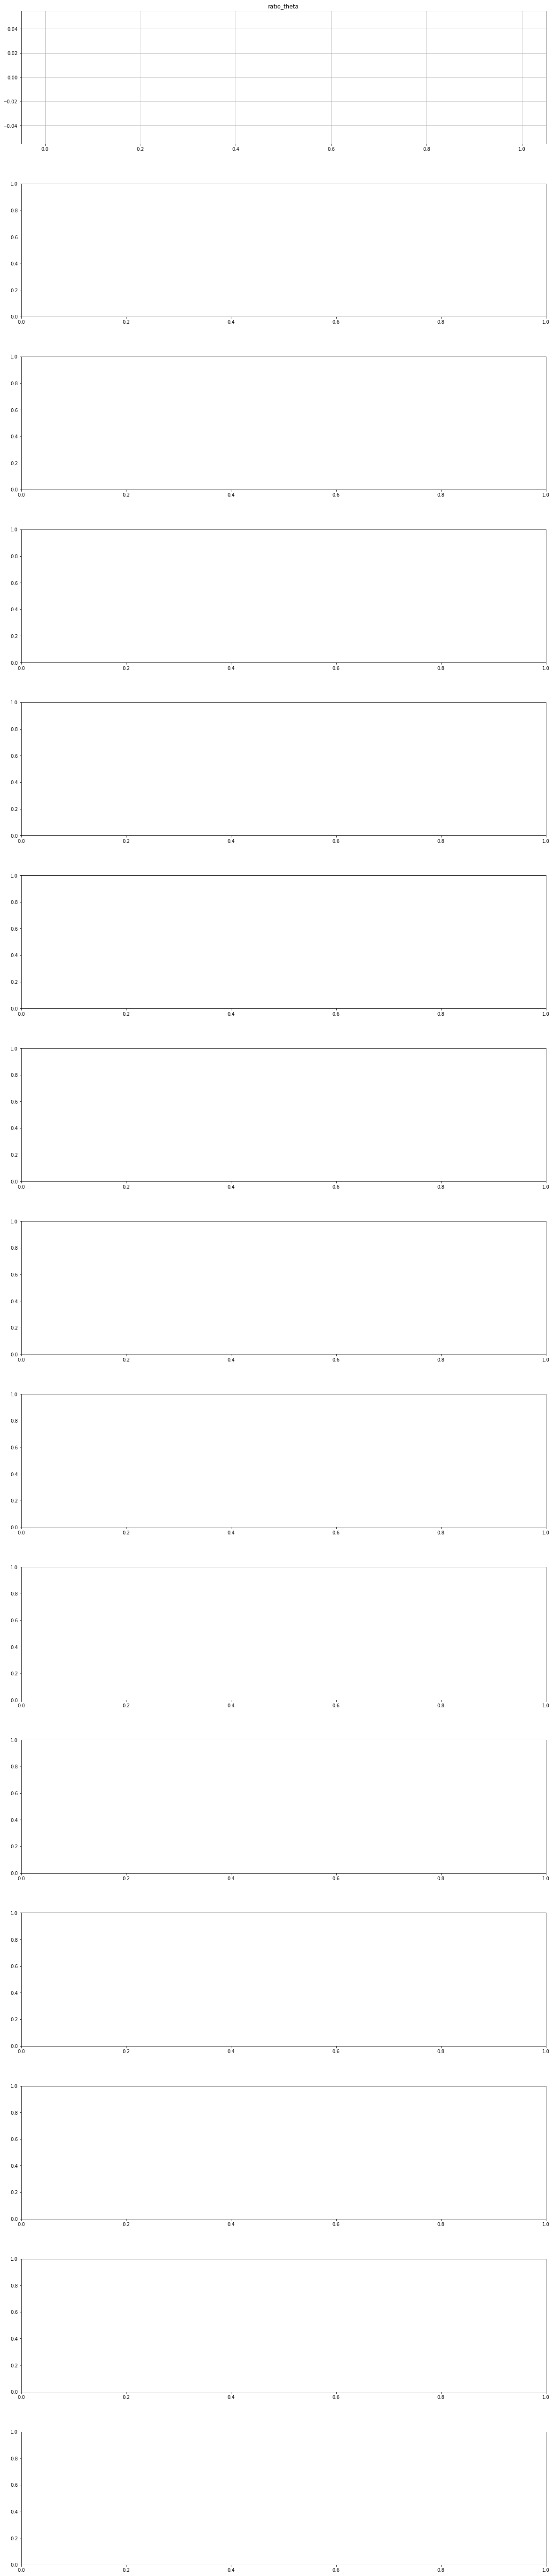

In [192]:
removing_mismatches["ratio_theta"] = removing_mismatches.theta_min/removing_mismatches.theta_max
removing_mismatches["ratio_phi"] = removing_mismatches.phi_min/removing_mismatches.phi_max
f, axes = plt.subplots(15,1, figsize=(20,100))
for i in range(15):
    ax = axes[i]
    removing_mismatches.loc[removing_mismatches.gen_min == i].hist('ratio_theta', ax=ax)
    plt.show()

ValueError: supplied range of [1.0, inf] is not finite

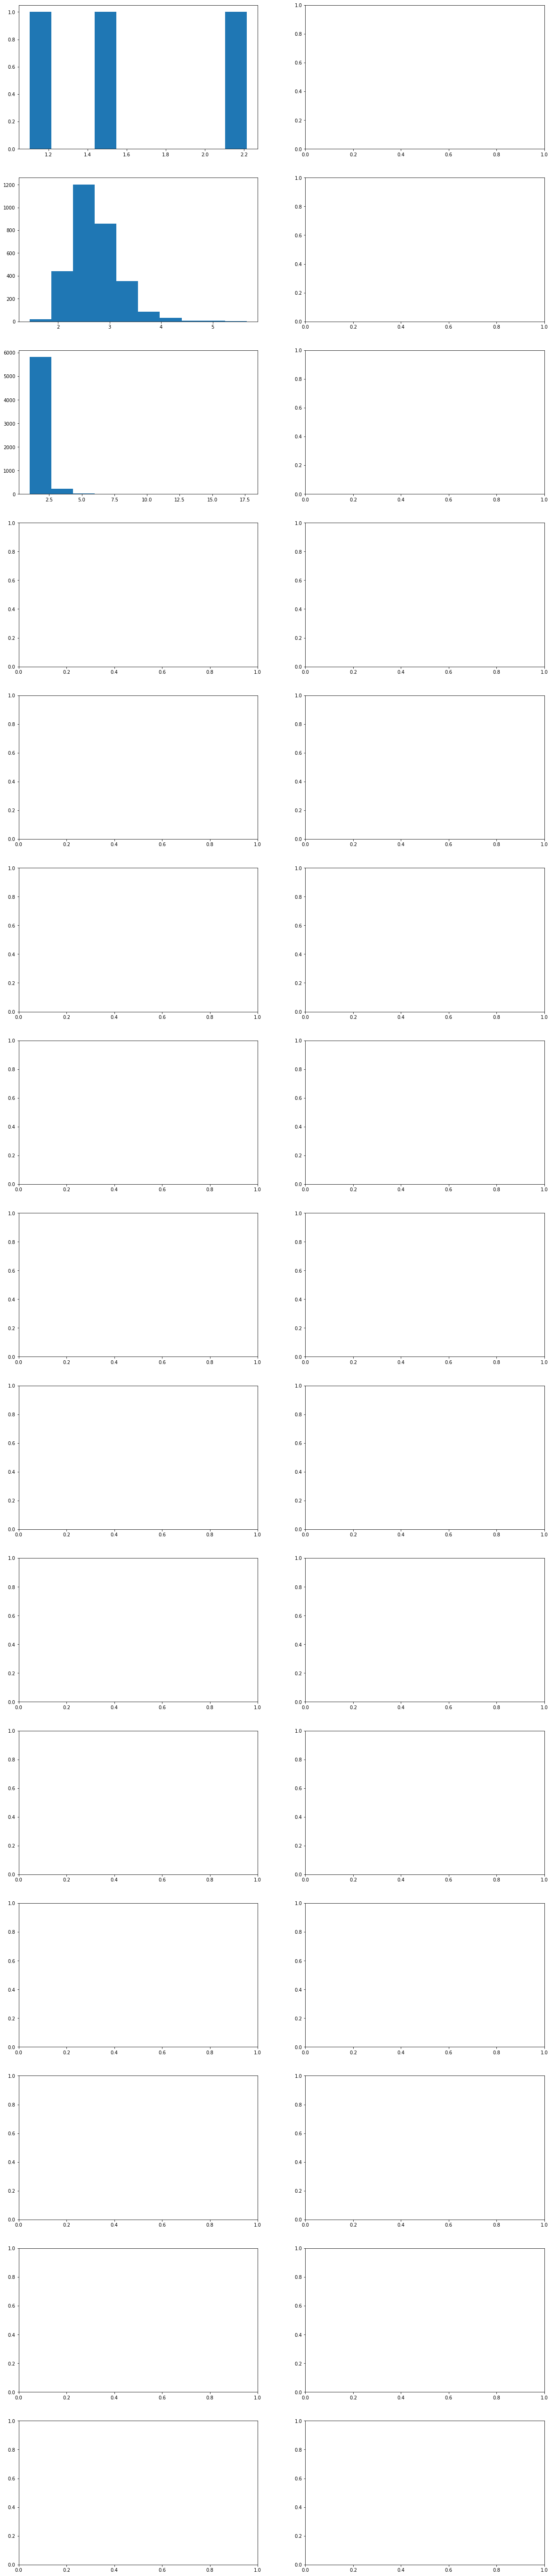

In [177]:
f, axes = plt.subplots(15,2, figsize=(20,100))
for i in range(15):
    ax = axes[i][0]
    curr_gen = per_branch_pt.loc[per_branch_pt[('gen','min')] == i]
    ratio = curr_gen[('theta', 'max')]/curr_gen[('theta', 'min')]
    ax.hist(ratio.values)

### Caliber Analysis

In [ ]:
display(df[df.avginnerarea > 0].avginnerarea.describe())
# group by weibel dim then plot the histogram
# excluding 3 outliers above 500 CSA --> Question error?
df_no_outlier = df[(df.avginnerarea > 0) & (df.avginnerarea < 500)]
df_no_outlier["log_diameter"] = np.log(2*np.sqrt(df_no_outlier["avginnerarea"]/np.pi))
df_no_outlier.plot(y="log_diameter", x="segmentalgeneration", style="x")

In [ ]:
np.polyfit(x=df_no_outlier.segmentalgeneration.values, y= df_no_outlier.log_diameter.values, deg=1) # outputs coeff of HIGHEST degree first
# not really woking --> could group by person, take avg per person per generation and tyr there maybe less noise?
# generate plots on the line


# regression = ols(x=df_no_outlier.weibel_generation, y=df_no_outlier.log_diameter)
# display(regression.summary) # slicing to only use last 30 points
# data = pd.DataFrame(index=x, data={'y': y, 'trend': trend})
# data.plot()

# df_no_outlier.plot(y="log_diameter", x="weibel_generation", style="x")
